### Model / representation error analysis

This notebooks contains several plots investigating the cross-validated errors across the many variable dimensions:
- split type [random, scaffold]
- sample size [500, ..., 2500]
- error metric [RMSE, MAE, R2, MAPE]
- error normalization [Yes, No]
- representation type [fingerprint, embedding, descriptor]
- similarity metric ["jaccard", "euclidean", "manhattan", "cosine"]
- representations [26 unique]
- datsets [12 unique]

In [4]:
import pandas as pd 
from utils import filter_df
from pathlib import PurePath

PROCESSED_DIR = PurePath("../topolearn/processed_data")
df = pd.read_csv(PROCESSED_DIR / "results.csv") 

# Ignored in paper
df = df[df["representation"] != "MolProp2"]

#### Plot 1: Error per representation for different model types

/tmp/ipykernel_1299225/1064932283.py:27: UserWarning: The palette list has more values (7) than needed (3), which may not be intended.
  ax = sns.scatterplot(x=x, y=y, data=tmp, hue=hue,
/tmp/ipykernel_1299225/1064932283.py:31: UserWarning: The palette list has more values (7) than needed (3), which may not be intended.
  p = sns.boxenplot(data=tmp, x=x, y=y, hue=hue,
/tmp/ipykernel_1299225/1064932283.py:27: UserWarning: The palette list has more values (7) than needed (3), which may not be intended.
  ax = sns.scatterplot(x=x, y=y, data=tmp, hue=hue,
/tmp/ipykernel_1299225/1064932283.py:31: UserWarning: The palette list has more values (7) than needed (3), which may not be intended.
  p = sns.boxenplot(data=tmp, x=x, y=y, hue=hue,
/tmp/ipykernel_1299225/1064932283.py:27: UserWarning: The palette list has more values (7) than needed (3), which may not be intended.
  ax = sns.scatterplot(x=x, y=y, data=tmp, hue=hue,
/tmp/ipykernel_1299225/1064932283.py:31: UserWarning: The palette list 

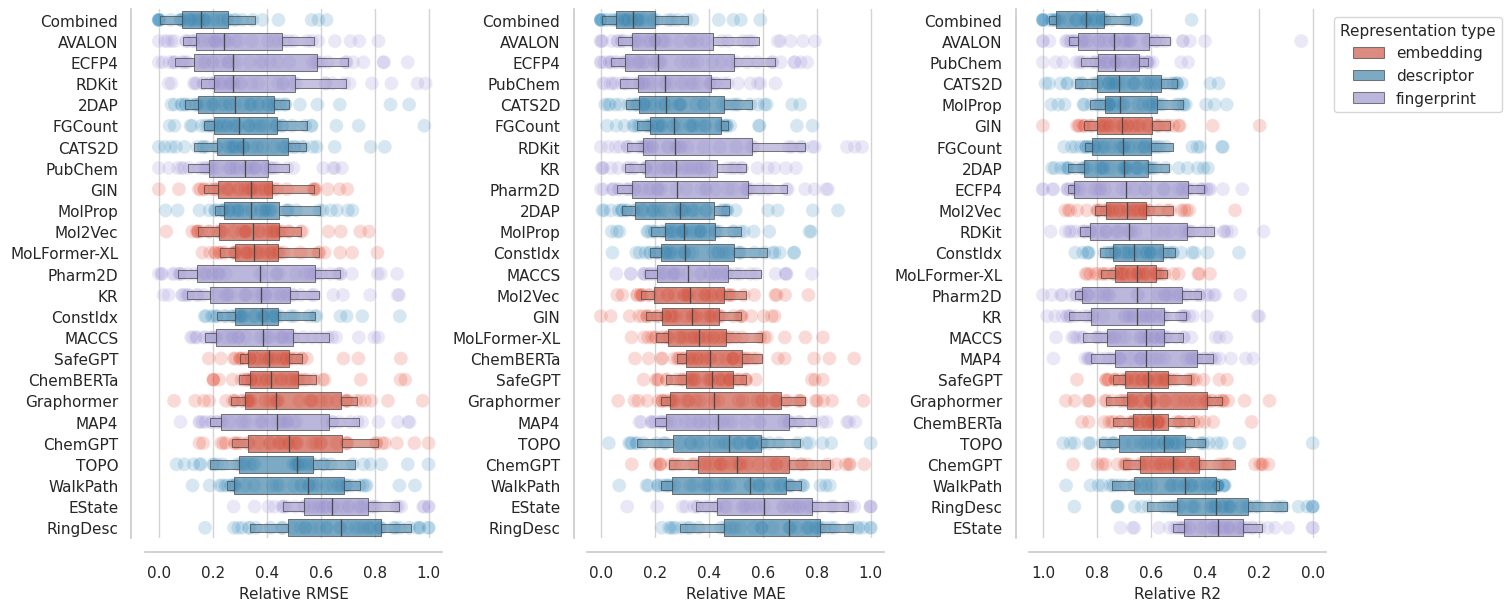

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from plotting import get_default_palette
from plotting import load_plot_config

load_plot_config()

Xs = ["Relative RMSE", "Relative MAE", "Relative R2"]
y = "representation"
hue = "representation_type"
hue_order = df[hue].unique()
fig, axs = plt.subplots(nrows=1, ncols=len(Xs), figsize=(15, 6), constrained_layout=True)

for idx, x in enumerate(Xs):
    filter = {
        "samples": {"gte": 1000},
        "split": "scaffold",
        "representation_type": {"all": None},
        "dataset": {"all": None},
        "distance_metric": {"all": None}
    }
    tmp = filter_df(df, filter).reset_index(drop=True)  
    tmp = tmp.merge(tmp.groupby(["representation"])[x].agg(center=("median")), how="left", on="representation")
    ascending = True if not "R2" in x else False
    tmp = tmp.sort_values(by="center", ascending=ascending)
    legend = True if (idx + 1) == len(Xs) else False
    ax = sns.scatterplot(x=x, y=y, data=tmp, hue=hue, 
                         hue_order=hue_order, alpha=0.2, 
                         s=100, legend=False, color="blue", 
                         ax=axs[idx], palette=get_default_palette()) 
    p = sns.boxenplot(data=tmp, x=x, y=y, hue=hue, 
                      hue_order=hue_order, showfliers=False, 
                      fill=True, alpha=0.7, legend=legend, 
                      ax=axs[idx], palette=get_default_palette()) 
    p.set_xlabel(x, fontsize=11)
     
    if legend:
        plt.legend(title='Representation type')
        plt.setp(p.get_legend().get_texts(), fontsize='8')
        plt.setp(p.get_legend().get_title(), fontsize='11')
        sns.move_legend(p, "upper left", bbox_to_anchor=(1, 1))
    
    if not ascending:
        plt.gca().invert_xaxis()

    ax.xaxis.grid(True, color='lightgray')
    ax.set(ylabel="")
    ax.set(xlabel=x)
    ax.set_axisbelow(True)
    sns.despine(offset=10)

fig.figure.savefig(f'plots/errors_{filter["split"]}.png', dpi=300)

#### Plot 2: Error variance

The representations perform more or less similar across seeds.

<Axes: ylabel='variance'>

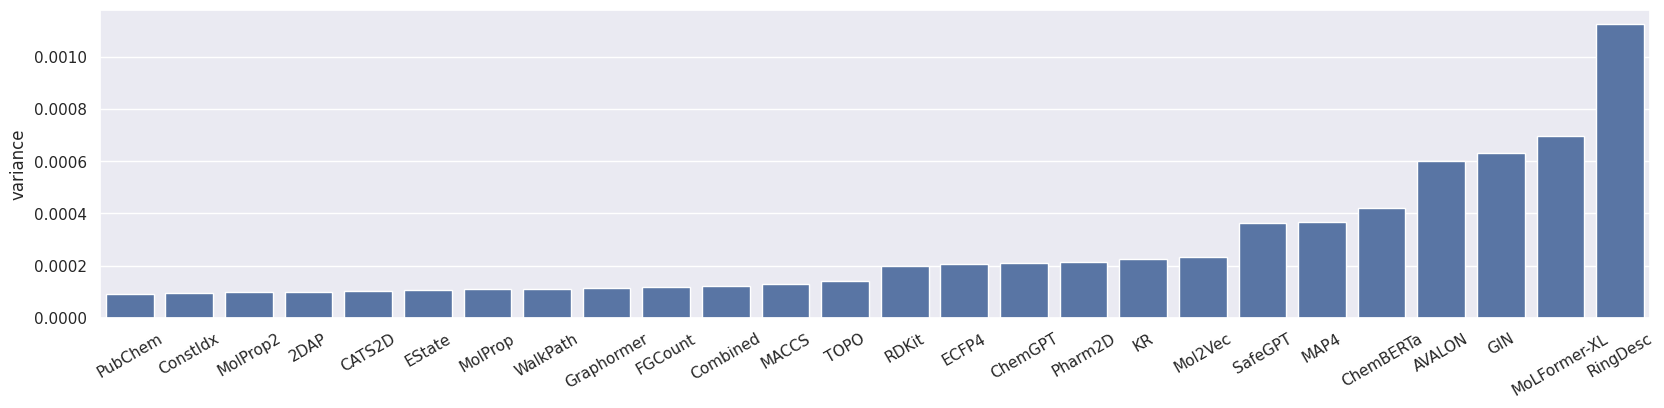

In [22]:
pltda = df.groupby(["representation"]).agg(variance = ("RMSE_var", "mean")).sort_values(by="variance").reset_index()
sns.set_theme(rc={'figure.figsize':(20, 4)})
plt.xticks(rotation=30)
sns.barplot(x=pltda.representation.values, y=pltda["variance"])

#### Plot 3: Ranking of error for each representation on different datasets

In [29]:
import altair as alt
import pandas as pd
from plotting import get_palettes

rankings = []
datasets = df.dataset.unique()
x = "Relative RMSE"

# Sort metric values for each dataset
for dat in datasets:
    filter = {
        "samples": 1000,
        "split": "random",
        "representation_type": {"all": None},
        "dataset": dat,
        "distance_metric": {"all": None}
    }
    tmp = filter_df(df, filter)
    tmp = tmp.sort_values(by=[x], ascending=True)
    d = tmp["representation"].reset_index(drop=True)
    rankings.append(d.values)
    
# Compute ranking index
ids = []
for rep in df["representation"].unique():
    for ranking, d in zip(rankings, datasets):
        if rep in ranking:
            argidx = list(ranking).index(rep)
            ids.append([argidx, rep, d])
        else:
            ids.append([len(ranking), rep, d])
ranking = pd.DataFrame(ids, columns=["rank", "representation", "dataset"])
grp = ranking.groupby("representation")["rank"].mean().reset_index().rename({"rank": "rank_avg"}, axis=1)
ranking = ranking.merge(grp, on="representation")

# Custom colors
rep_palette, _ = get_palettes()
custom_scale = alt.Scale(domain=list(rep_palette.keys()), range=list(rep_palette.values()))

# Plotting
alt.Chart(ranking.sort_values(by="rank")).mark_line(point=True, opacity=0.7).encode(
    x=alt.X('dataset', title='Dataset', axis=alt.Axis(labelAngle=-45)),
    y=alt.Y('rank:O', scale=alt.Scale(reverse=False), title="Rank"),
    color=alt.Color("representation:N", title="Representation").scale(custom_scale),
    strokeWidth=alt.condition(
        "datum.rank_avg <= 5",
        alt.value(7),
        alt.value(3))
).properties(
    width=1200,
    height=400
).configure_axis(
    labelFontSize=14,
    titleFontSize=16,
    labelFont="Arial",
    titleFont='Arial',
    titleFontWeight='normal'
).configure_legend(
    labelFontSize=12,
    titleFontSize=14,
    labelFont='Arial',
    titleFont='Arial',
    titleFontWeight='normal'
)

alt.Chart(...)

#### Plot 4: Heatmap of mean error accross representations and datasets

- **Note**: For this plot, we normalized the scores additionally by sample size to ensure ranges of [0, 1]. See notebook 01_dataset_processing (select sample_size in aggregation).
- It clearly shows which datasets are generally more difficult (more red) and which representations perform good (more blue)

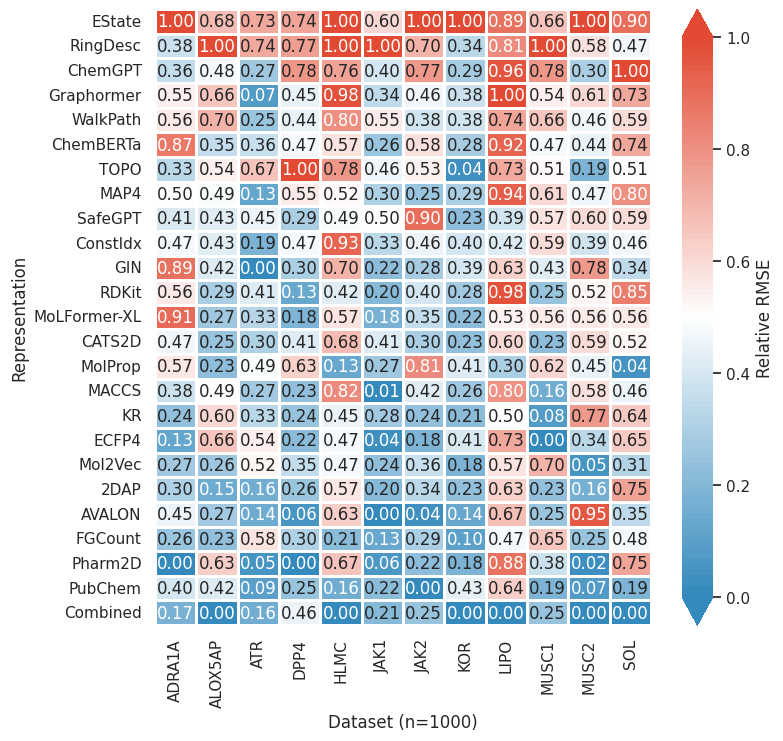

In [7]:
import seaborn as sns
from plotting import load_plot_config

sns.set_theme(rc={'figure.figsize':(5,3)})
sns.set_theme(style="ticks")
load_plot_config()

filter = {
    "samples": 1000,
    "split": "scaffold",
    "representation_type": {"all": None},
    "dataset": {"all": None},
    "distance_metric": {"all": None}
}

heat = "Relative RMSE"
subset = filter_df(df, filter).reset_index(drop=True)
t = subset.groupby(["representation", "dataset"])[heat].mean().reset_index()
vals = t.pivot(index="representation", columns="dataset", values=heat)

# Sort by row mean
vals_sorted = vals.assign(m=vals.mean(axis=1)).sort_values('m', ascending=False).drop('m', axis=1)

# Style config
sns.set_theme(rc={'figure.figsize':(8, 8)})
palette = sns.blend_palette(["#348ABD", "#FFF", "#E24A33"], n_colors=100)
cbar_kws = {
            'extend':'both',
            'label': 'Relative RMSE'
           } 

ax = sns.heatmap(vals_sorted,cbar_kws=cbar_kws, cmap=palette, xticklabels=True, yticklabels=True, annot = True, fmt=".2f", linewidths=1)
ax.set(ylabel="Representation", xlabel=f"Dataset (n={filter['samples']})")
ax.figure.savefig(f'plots/errors_heatmap_{filter["split"]}.png', bbox_inches='tight', dpi=300)

#### Plot 5: Errors per sample size per representation

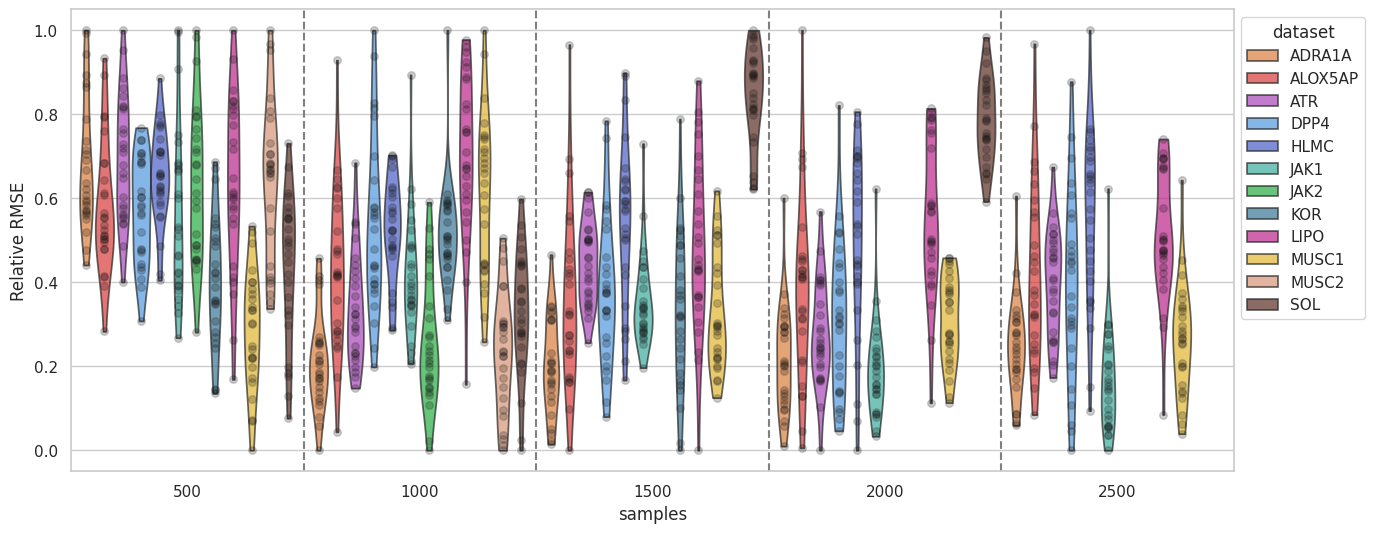

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns
from plotting import get_palettes, load_plot_config
sns.set_theme(rc={'figure.figsize':(15, 6)})
load_plot_config()
_, dataset_colors = get_palettes()


filter = {
    "split": "scaffold"
}

y = "Relative RMSE"
subset = filter_df(df, filter).reset_index(drop=True).sort_values(by="dataset")
p = sns.violinplot(subset, x="samples", y=y, hue="dataset", cut=0, palette=sns.color_palette(dataset_colors.values()), inner="point",
                   inner_kws=dict(color="black", s=30, alpha=0.2), width=0.95, alpha=0.7)

for i in range(len(subset["samples"].unique()) - 1):
    plt.axvline(i + 0.5, color='gray', linestyle='--')

sns.move_legend(p, "upper left", bbox_to_anchor=(1, 1))
p.figure.savefig(f'plots/errors_datasets_{filter["split"]}.png', bbox_inches='tight', dpi=300)

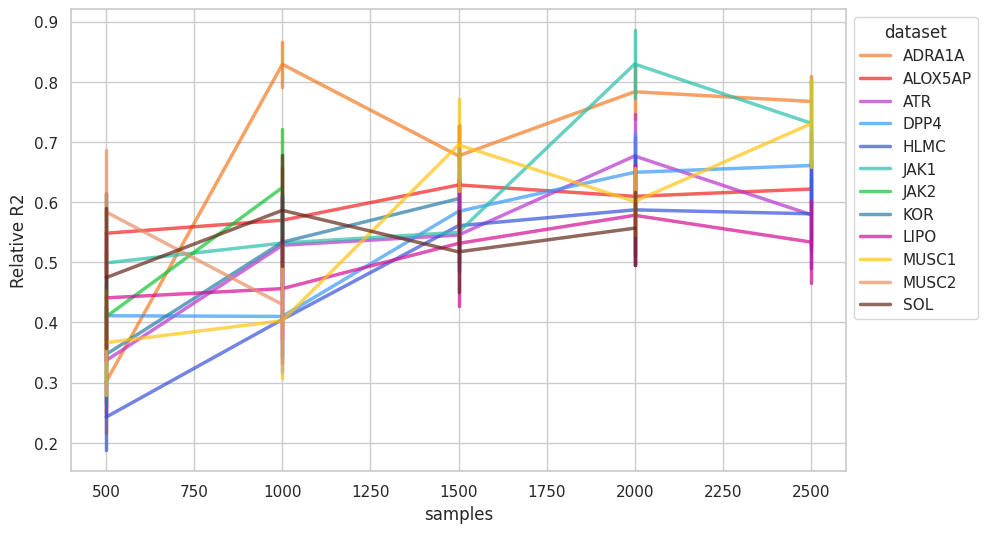

In [128]:
sns.set_theme(rc={'figure.figsize':(10, 6)})
load_plot_config()
p = sns.lineplot(subset, x='samples', y="Relative R2", hue="dataset", linewidth=2.5, alpha=0.7, err_kws={'elinewidth': 2.5},
             err_style='bars', errorbar=('se', 2), palette=sns.color_palette(dataset_colors.values()))
sns.move_legend(p, "upper left", bbox_to_anchor=(1, 1))
p.figure.savefig(f'plots/errors_datasets_{filter["split"]}.png', bbox_inches='tight', dpi=300)

#### Plot 6: Dimensionality vs. Error

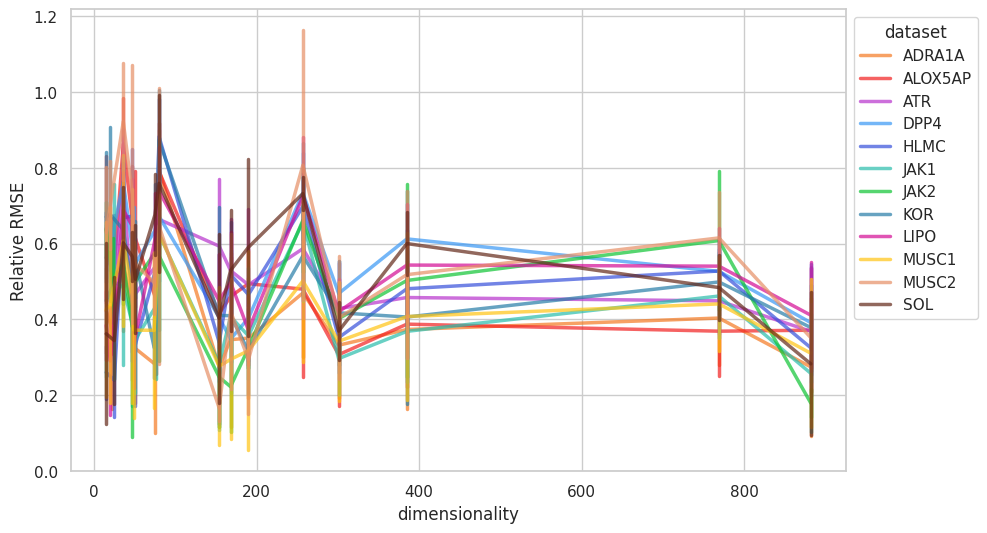

In [132]:
sns.set_theme(rc={'figure.figsize':(10, 6)})
load_plot_config()

filter = {
    "split": "random",
    "dimensionality": {"lte": 1024}
}

y = "Relative RMSE"
subset = filter_df(df, filter).reset_index(drop=True).sort_values(by="dataset")

p = sns.lineplot(subset, x='dimensionality', y=y, hue="dataset", linewidth=2.5, alpha=0.7, err_kws={'elinewidth': 2.5},
             err_style='bars', errorbar=('se', 2), palette=sns.color_palette(dataset_colors.values()))
sns.move_legend(p, "upper left", bbox_to_anchor=(1, 1))
p.figure.savefig(f'plots/errors_dimensionality_{filter["split"]}.png', bbox_inches='tight', dpi=300)